Proposed Trading Strategy
-----
-  We place bids and asks at ALL times on levels 2, 3, 4, and 5. 
-  We place the orders above in an effort to gain valuable queue positions on our level 2-bid/ask orders.
-  When our queue position on our level 2 bid or ask orders reaches the top X% of the queue (X set to like 5% or 10%) we activate our strategy for the given direction.
-  Only when our strategy is active do we place any level 1 orders.
-  Now of course it is impossible to know the relative queue position in practice but it can be estimated fairly accurately, so here we will use the actual queue position (or add in some noise if desired).
-  Once our strategy is active, we look at our RNN predictions for next_midprice_move.
-  Given a positive (negative) price move signal, we place a limit buy (sell) order on the level 1 ask (bid). This order is immediately executed (as it is in a sense a market order).
-  We then wait until the midprice spread changes. If we predict the movement correctly, with high probability, we will make the spread once our level 2 order is filled. 
-  When we predict incorrectly, to avoid further loss, we close our position and in most cases lose double the spread.
-  We continue to repeat this process.


In [1]:
import pandas as pd
import numpy as np
import os
import math
import sys
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
sys.path.insert(0, os.path.join(os.getcwd(), 'code'))

import OrderBook as ob
import OrderUtil as ou
import TradingStrategySimulator as tss


In [2]:
#load in intc OrderBook data
book = ob.OrderBook(message_filename='INTC_message.csv', orderbook_filename='INTC_OrderBook.csv')

Perfectly Accurate Model
--------
Here we use an ideal 100% accurate model to see whether or not our strategy can be profitable

In [3]:
strat = {1: ([2, 3, 4, 5], [2, 3, 4, 5]),
         -1 : ([2, 3, 4, 5], [2, 3, 4, 5])}
midprice_df = book.get_midprice_data(numupdates=1, t_start=37000, t_end=40000, tick_size=100, next_move=True)
midprice_df.dropna(inplace=True)
backtester = tss.StrategyLossEstimation(book=book, midprice_df=midprice_df, mkt_order_on_move_predictions=True,
                                        strategy=strat,
                                        max_exposure_dict={1:0, -1:0}, relative_queue=0.25, 
                                        set_edge_queue=0.25, accuracy_rate=1, tick_size=100, queue_tol=0.5)

1.0
Current time:        37000.012826949
Current pnl: 0.0
Current time:        37013.463272664
Current pnl: 0.0
Current time:        37123.125654154
Current pnl: 0.0
Current time:        37148.081184202005
Current pnl: 0.0
Current time:        37162.868263961
Current pnl: 0.0
Current time:        37219.220431059
Current pnl: 0.0
Current time:        37288.514622768
Current pnl: 0.0
Current time:        37324.266627746
Current pnl: 0.0
Current time:        37348.729683769
Current pnl: 0.0
Current time:        37418.522190809
Current pnl: 0.0
Current time:        37496.807132705
Current pnl: 0.0
market sell at 273000
Current time:        37548.643720295
Current pnl: -50.0
limit bid executed at 272900
market sell at 272900
limit bid executed at 272800
Current time:        37563.913376312004
Current pnl: 200.0
Current time:        37596.827021719
Current pnl: 200.0
Current time:        37677.548952123
Current pnl: 200.0
market buy at 273300
limit ask executed at 273400
market buy at 273400

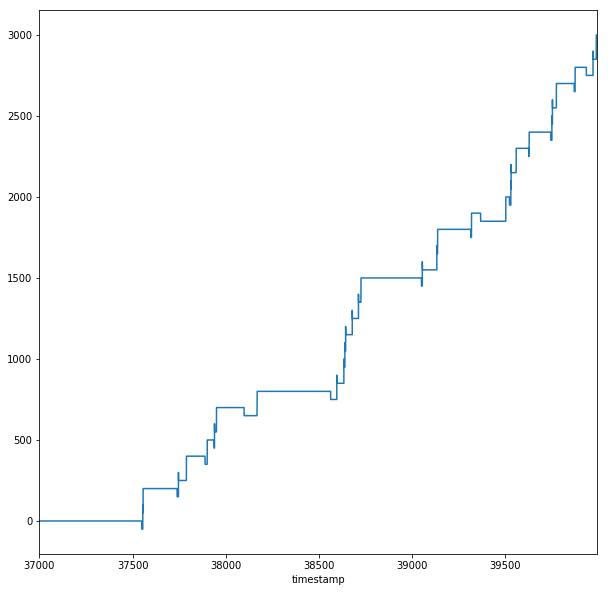

In [4]:
pnls = backtester._strategy_simulator.get_pnl_series()
pnls.cumsum().plot()
plt.show()

70% Accuracy
---------
Here we test a hypothetical model that has an average of 70% out of sample accuracy

In [5]:
strat = {1: ([2, 3, 4, 5], [2, 3, 4, 5]),
         -1 : ([2, 3, 4, 5], [2, 3, 4, 5])}
midprice_df = book.get_midprice_data(numupdates=1, t_start=37000, t_end=40000, tick_size=100, next_move=True)
midprice_df.dropna(inplace=True)
backtester = tss.StrategyLossEstimation(book=book, midprice_df=midprice_df, mkt_order_on_move_predictions=True,
                                        strategy=strat,
                                        max_exposure_dict={1:0, -1:0}, relative_queue=0.25, 
                                        set_edge_queue=0.25, accuracy_rate=0.7, tick_size=100, queue_tol=0.5)

0.7014588953570922
Current time:        37000.012826949
Current pnl: 0.0
Current time:        37013.463272664
Current pnl: 0.0
Current time:        37123.125654154
Current pnl: 0.0
Current time:        37148.081184202005
Current pnl: 0.0
Current time:        37162.868263961
Current pnl: 0.0
Current time:        37219.220431059
Current pnl: 0.0
Current time:        37288.514622768
Current pnl: 0.0
Current time:        37324.266627746
Current pnl: 0.0
Current time:        37348.729683769
Current pnl: 0.0
Current time:        37418.522190809
Current pnl: 0.0
Current time:        37496.807132705
Current pnl: 0.0
market sell at 273000
Current time:        37548.643720295
Current pnl: -50.0
limit bid executed at 272900
market sell at 272900
limit bid executed at 272800
market sell at 272800
Current time:        37563.913376312004
Current pnl: 0.0
Current time:        37596.827021719
Current pnl: 0.0
Current time:        37677.548952123
Current pnl: 0.0
market buy at 273300
limit ask executed

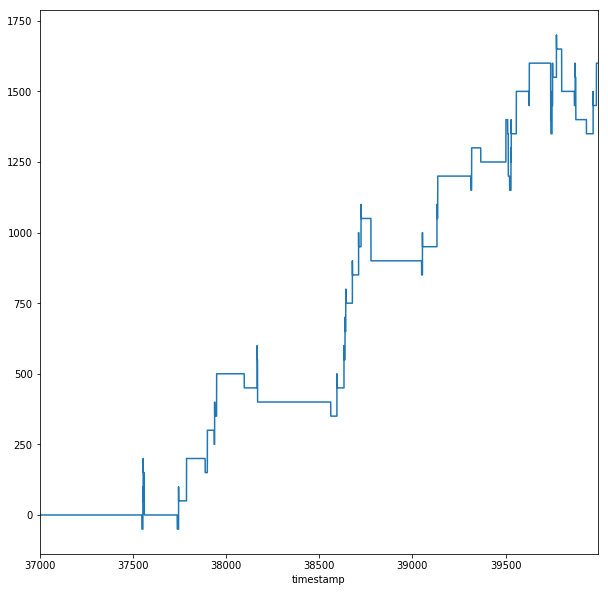

In [6]:
pnls = backtester._strategy_simulator.get_pnl_series()
pnls.cumsum().plot()
plt.title('PNL for 70% accuracy from epoch 37000 to 40000')
plt.show()